In [2]:
import fiona
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from time import time
from tqdm import tqdm
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.colors as colors
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

seed = 1234
np.random.seed(seed)

## 1. Read Xarray Files


In [3]:
def get_filenames(directory):
    filenames = sorted(os.listdir(directory))
    return [f for f in filenames if f.endswith(".nc")]


def get_path(directory, filename):
    return os.path.join(directory, filename)


def get_basename(path):
    return os.path.basename(path)


def get_month_year(file_name, dtype="ppt"):
    """Get month and year from file name"""
    if dtype == "ppt":
        time = pd.Timestamp("-".join(file_name.split(".")[0].split("_")[1:]))
        month, year = time.month, time.year
    elif dtype == "sst":
        year, month = file_name.split(".")[-2][-6:-2], file_name.split(".")[-2][-2:]
        month, year = int(month), int(year)
    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")
        month, year = None, None
    return month, year


def read_xr(path, dtype="ppt"):
    """Read xarray file"""
    file_data = xr.load_dataset(path, engine="netcdf4")
    file_name = get_basename(path)
    month, year = get_month_year(file_name, dtype)
    xr_data = [file_name, year, month]

    if dtype == "ppt":
        file_data = file_data.rename_vars(
            {list(file_data.keys())[1]: "ppt", "longitude": "lon", "latitude": "lat"}
        )

        # Coarsen data to reduce resolution
        file_data = file_data.coarsen(latitude=4, longitude=4, boundary="trim").mean()
        #         file_data = file_data.sel(longitude=slice(-300, -100))

        ##Slice for west coast
        file_data = file_data.sel(longitude=slice(0, 150))

        xr_data.append(file_data.ppt.values)
        columns = list("FYMD")
        columns[-1] = "ppt"

    elif dtype == "sst":
        # Coarsen data to reduce resolution
        #         file_data = file_data.coarsen(lat = 4, lon = 4, boundary = "trim").mean()

        ##Slice for west coast
        #         file_data = file_data.sel(lon=slice(100, 400))

        xr_data.extend([file_data.sst.values, file_data.ssta.values])
        columns = list("FYMDA")
        columns[-2], columns[-1] = "sst", "ssta"

    else:
        print(f"dtype {dtype} not implemented. Use ppt or sst.")

    longitude, latitude = file_data.lon.values, file_data.lat.values
    return xr_data, longitude, latitude, columns


def load_data(directory, dtype="ppt"):
    """Load directory files in a pandas dataframe"""
    filenames = get_filenames(directory)
    data_info_list = []
    for i, file_name in tqdm(enumerate(filenames)):
        path = get_path(directory, file_name)
        xr_data, longitude, latitude, columns = read_xr(path, dtype)
        data_info_list.append(xr_data)
    df = pd.DataFrame([p for p in data_info_list], columns=columns)
    return df, latitude, longitude

#### `Change ppt_directory and sst_directory based on your directories`


In [4]:
ppt_directory = "data/ppt-nc-1895-2020"
sst_directory = "data/ERSST"

In [5]:
### Load ppt data
ppt_df, lat, lon = load_data(ppt_directory, dtype="ppt")

0it [00:00, ?it/s]

759it [00:34, 22.06it/s]


### PPT Levels in different U.S. States


In [6]:
def show_states(west_coast=True, state_file="States/cb_2018_us_state_20m.shp"):
    shape = fiona.open(state_file)
    for s in shape:
        pts = s["geometry"]["coordinates"]
        for p in pts:
            state = np.array(p).squeeze()
            if state[:, 1].min() < 50 and state[:, 1].min() > 22:
                if not west_coast:
                    plt.plot(state[:, 0], state[:, 1], color="black")
                elif np.max(state[:, 0]) < -100:  # plot only west coast
                    plt.plot(state[:, 0], state[:, 1], color="black")

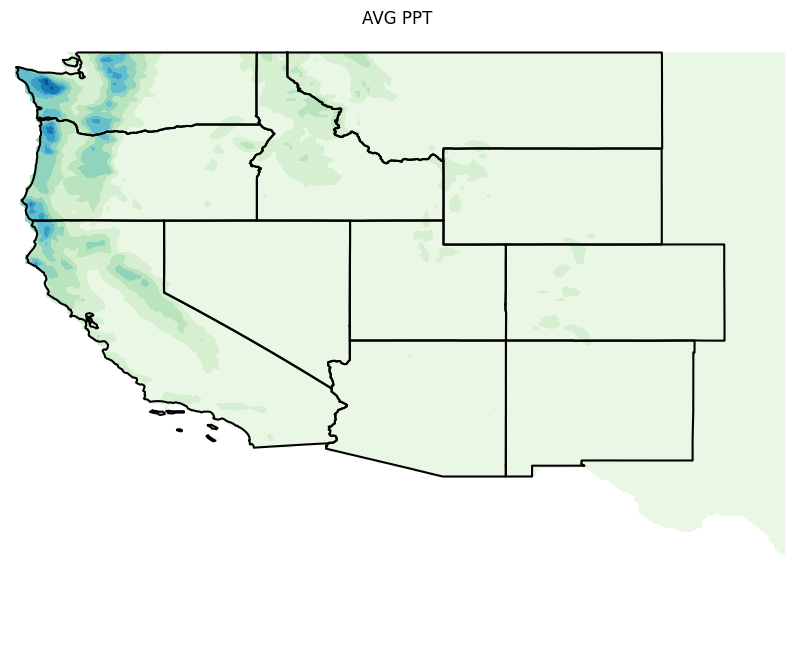

In [7]:
avg_ppt = ppt_df["ppt"].mean()

plt.figure(figsize=(10, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, avg_ppt, cmap="GnBu")
show_states()
plt.axis("off")
plt.title("AVG PPT")
plt.show()
plt.close()

In [8]:
### Load sst data
sst_df, _, _ = load_data(sst_directory, dtype="sst")
sst_df

1644it [00:17, 94.32it/s] 


,F,Y,M,sst,ssta
0,ersst.v5.188001.nc,1880,1,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1,ersst.v5.188002.nc,1880,2,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
2,ersst.v5.188003.nc,1880,3,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
3,ersst.v5.188004.nc,1880,4,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
4,ersst.v5.188005.nc,1880,5,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
...,...,...,...,...,...
1639,ersst.v5.201608.nc,2016,8,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1640,ersst.v5.201609.nc,2016,9,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1641,ersst.v5.201610.nc,2016,10,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...
1642,ersst.v5.201611.nc,2016,11,[[[[nan nan nan nan nan nan nan nan nan nan na...,[[[[nan nan nan nan nan nan nan nan nan nan na...


### SST Levels


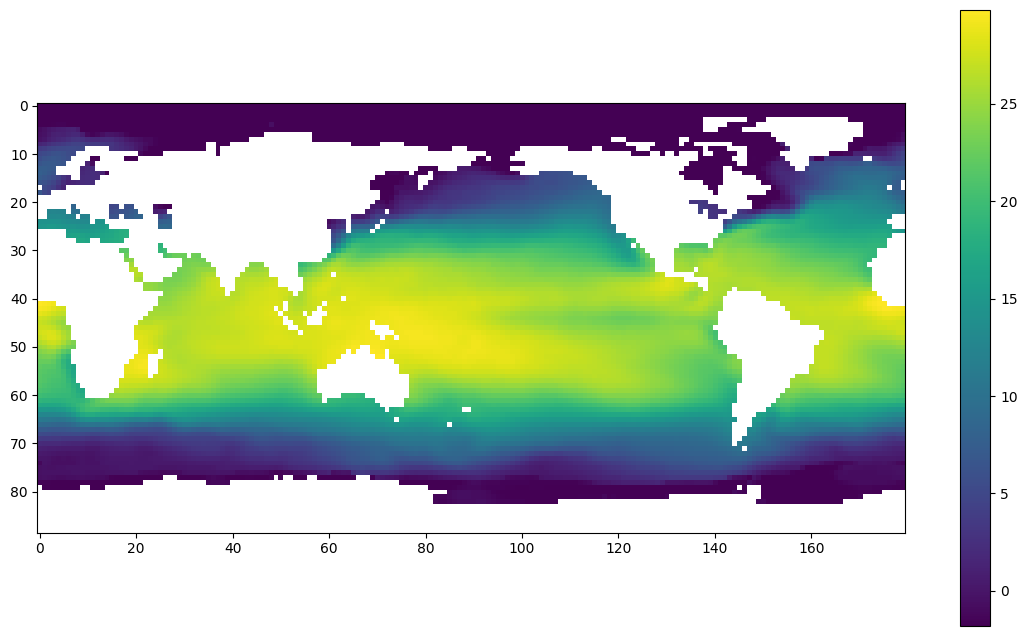

(1644,)

In [9]:
plt.figure(figsize=(14, 8))
sst_example = sst_df["sst"].iloc[0]
plt.imshow(np.flipud(sst_example.reshape(sst_example.shape[-2], sst_example.shape[-1])))
plt.colorbar()
plt.show()
sst_df["sst"].shape

In [10]:
## Check shapes of ppt and sst
sst_df["sst"].iloc[0].shape, ppt_df["ppt"].iloc[0].shape

((1, 1, 89, 180), (155, 150))

In [11]:
# get rainfall month and year
rain_row = ppt_df.iloc[0]
m, y = rain_row["M"], rain_row["Y"]

# get sst month and year
sst_row = sst_df[(sst_df["M"] == m) & (sst_df["Y"] == y)]  # bitmask filters for month and year
index_position = sst_row.index[0]  # index returns Index object, so we need to get the first element

# if index_position < 24:
#     # do something, though this should never happen cuz sst starts far earlier

prev24 = sst_df.iloc[index_position - 24 : index_position]

In [12]:
import pandas as pd

# Sample DataFrame
data = {
    "month": [1, 5, 7, 5, 12],
    "year": [2020, 2021, 2021, 2022, 2020],
    "data": ["A", "B", "C", "D", "E"],  # Additional data column for illustration
}
df = pd.DataFrame(data)

# Your target month and year
target_month = 5
target_year = 2021

# Create a boolean mask to filter the DataFrame
mask = (df["month"] == target_month) & (df["year"] == target_year)

# Apply the mask to the DataFrame
filtered_df = df[mask]

# Display the filtered DataFrame
print(filtered_df)

   month  year data
1      5  2021    B


## 2. Combine SST and PPT


In [13]:
df = sst_df.merge(ppt_df, on=["Y", "M"], suffixes=("_sst", "_ppt"), how="inner")

## 3. Add Temporal Features


In [14]:
def add_time(df):
    """Add Time Column"""
    min_year = np.min(df["Y"])
    df["T"] = (df["Y"] - min_year) * 12 + df["M"]
    return df


def add_season(df):
    """adds Season Column (0 for months 1,2,3 and 1 for months 10,11,12)"""
    df["season"] = ((df["M"] - 1) // 4).astype(bool).astype(int)
    return df


df = add_season(add_time(df))
df.to_csv("data/df.csv", index=False)

### ppt has data for only months 1,2,3,10,11,12. While sst has all months.


## 4. Add Clusters


In [15]:
clusters = np.load("clusters.npy")

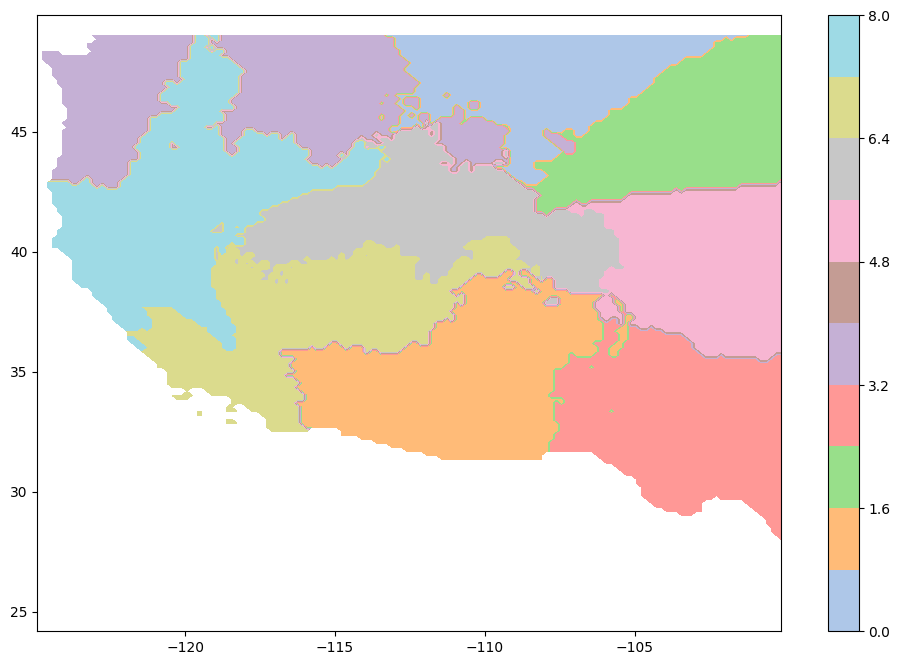

np.unique(clusters):  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]


In [16]:
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.show()
print("np.unique(clusters): ", np.unique(clusters))

In [17]:
def average_clusters(image, cluster_array, return_image=True):
    """Average the values of each cluster in the image"""
    unique_clusters = np.unique(cluster_array)  # Find unique cluster labels

    if return_image:
        # Initialize an array to store the average values
        averaged_image = np.zeros_like(image, dtype=float)
    else:
        cluster_averages = []

    for cluster_label in unique_clusters:
        # Mask the original image with the current cluster label
        masked_image = np.where(cluster_array == cluster_label, image, 0)

        # Calculate the average value for the current cluster
        cluster_size = np.sum(cluster_array == cluster_label)
        cluster_average = np.sum(masked_image) / cluster_size

        if return_image:
            # Replace pixels in the averaged image with the cluster average
            averaged_image += np.where(
                cluster_array == cluster_label, cluster_average, 0
            )
        else:
            cluster_averages.append(cluster_average)

    return averaged_image if return_image else np.array(cluster_averages)


avg_clusters = average_clusters(df.iloc[0].ppt, clusters)
avg_clusters

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_14135/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

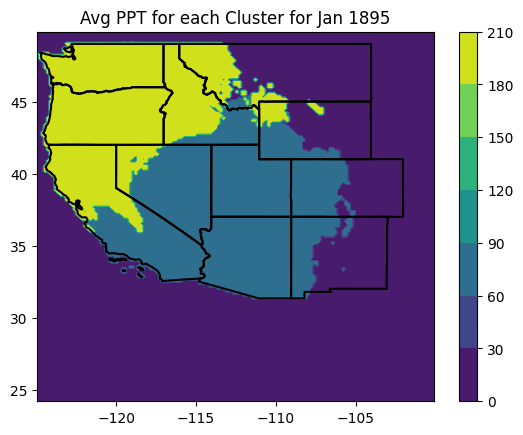

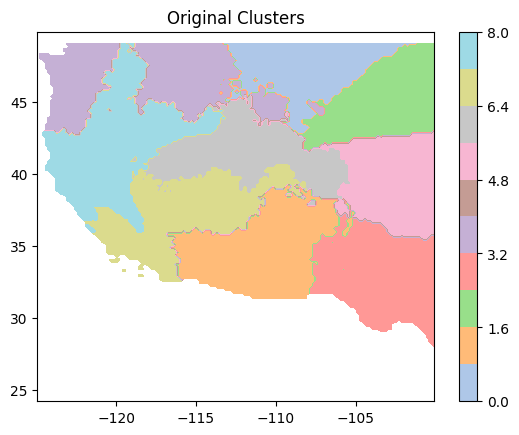

In [18]:
plt.contourf(xx, yy, avg_clusters)
plt.colorbar()
show_states()
plt.title("Avg PPT for each Cluster for Jan 1895")
plt.show()

xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, clusters, levels=10, cmap="tab20")
plt.colorbar()
plt.title("Original Clusters")
plt.show()

In [19]:
df["ppt_cluster"] = df["ppt"].apply(lambda x: average_clusters(x, clusters))
df["ppt_cluster_vector"] = df["ppt"].apply(
    lambda x: average_clusters(x, clusters, return_image=False)[:-1]
)

/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_14135/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_14135/790362116.py:17: RuntimeWarning: invalid value encountered in divide
  cluster_average = np.sum(masked_image) / cluster_size


## 5. Add Quantiles


In [20]:
def get_quantiles(df, cluster=True):

    vector = df.ppt_cluster_vector if cluster else df.ppt

    ppt_vector = np.stack(vector.apply(lambda x: x.reshape(-1))).T
    q1 = np.quantile(ppt_vector, 0.25, axis=1, keepdims=True).flatten()
    q2 = np.quantile(ppt_vector, 0.5, axis=1, keepdims=True).flatten()
    q3 = np.quantile(ppt_vector, 0.75, axis=1, keepdims=True).flatten()
    return q1, q2, q3


q1, q2, q3 = get_quantiles(df)
q1

array([ 9.5338221 , 12.17312131,  9.24412442,  7.47316639, 94.40965887,
        8.27551748, 25.58297759, 13.8765325 , 42.52929087])

In [21]:
def get_quantized(x, q1, q2, q3):
    output = np.zeros_like(x)
    output[x <= q1] = 1
    q2_arr = np.array(x > q1) * np.array(x <= q2)
    q3_arr = np.array(x > q2) * np.array(x <= q3)
    output[q2_arr] = 2
    output[q3_arr] = 3
    output[x > q3] = 4
    return output

In [22]:
df["ppt_cluster_vector_quantized"] = df["ppt_cluster_vector"].apply(
    lambda x: get_quantized(x, q1, q2, q3)
)
df[["T", "M", "ppt_cluster_vector_quantized"]]

,T,M,ppt_cluster_vector_quantized
0,1,1,"[4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0]"
1,2,2,"[3.0, 3.0, 3.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0]"
2,3,3,"[2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0]"
3,10,10,"[1.0, 3.0, 1.0, 4.0, 1.0, 3.0, 1.0, 1.0, 1.0]"
4,11,11,"[4.0, 4.0, 4.0, 4.0, 2.0, 3.0, 3.0, 2.0, 1.0]"
...,...,...,...
727,1454,2,"[1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0]"
728,1455,3,"[3.0, 1.0, 4.0, 2.0, 4.0, 4.0, 4.0, 3.0, 4.0]"
729,1462,10,"[4.0, 1.0, 4.0, 2.0, 4.0, 2.0, 4.0, 2.0, 4.0]"
730,1463,11,"[2.0, 3.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0]"


## Organizing Data into y_labels and x_input

Want to create a dataframe of sea surface temperature input for each cluster precipitation estimation (1, 2, 3, or 4).
The input data should be 24 months worth of sea surface temperature data. This data is stored in a quadruple vector.
For each a ppt_cluster_vector quantity, grab the last 24 months of "sst" quadruple vector data information.
to test.


### Organizing Y Labels and processing ppt clusters


In [23]:
y_labels = df.loc[:,["Y", "M", "ppt_cluster_vector_quantized"]]
y_labels = y_labels.rename(columns={"M": "month", "Y": "year"})
y_labels["date"] = pd.to_datetime(y_labels[["month","year"]].assign(day=1))
y_labels["date"] = y_labels['date']

y_labels.drop(["month"], axis=1, inplace=True)
y_labels.drop(["year"], axis=1, inplace=True)
y_labels.set_index("date", inplace=True)

ppt_data = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
# get all 9 clusters in a list, where each cluster is the ith column in ppt_data
clusters = [np.array([x[i] for x in ppt_data]) for i in range(len(ppt_data[0]))]
clusters = np.array(clusters)

In [24]:
sst_condensed = sst_df.loc[:,["Y", "M", "sst"]]
sst_condensed = sst_condensed.rename(columns={"M": "month", "Y": "year"})
sst_condensed["date"] = pd.to_datetime(sst_condensed[["month","year"]].assign(day=1))
sst_condensed["date"] = sst_condensed['date']

sst_condensed.drop(["month"], axis=1, inplace=True)
sst_condensed.drop(["year"], axis=1, inplace=True)
sst_condensed.set_index("date", inplace=True)

### Process sst data for forest tree classification on entire dataset


In [25]:
x_input_rows = []
for date in y_labels.index:
    start_date = date - pd.DateOffset(months=23)
    end_date = date
    sst_in_range = np.array(sst_condensed.loc[start_date:end_date, 'sst'].tolist()) # shape here is (24, 1, 1, 89, 180)
    IO_TP_sst_in_range = sst_in_range.flatten() #1 x 384480
    sst_in_range = sst_in_range[~np.isnan(sst_in_range)] # 263712
    
    x_input_rows.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

x_input = pd.DataFrame(x_input_rows)
x_input["start date"] = x_input["start date"].dt.to_period('M')
x_input["end date"] = x_input["end date"].dt.to_period('M')
sst_data_all = np.array([xi.tolist() for xi in np.array(x_input[:]["sst rows"])])

### Check if y labels are distributed


In [26]:
# put all data from y_labels into a single, one-dimensional array
ppt_data_all = np.array(y_labels["ppt_cluster_vector_quantized"]) - 1
ppt_data_all = np.array([[y for y in x] for x in ppt_data_all])
ppt_data_all.reshape(1, -1)
# count the number of times each label appears in the data
unique, counts = np.unique(ppt_data_all, return_counts=True)
d = dict(zip(unique, counts))
d

{0.0: 1647, 1.0: 1647, 2.0: 1647, 3.0: 1647}

### Process data for PCA pre-processing with regions

We need to split the data into the following regions, so we use array slicing

![](PCA_regions.png)

Now that we have the regions, we'll split the sst data into regions using these approximate coordinates we have estimated. Once the data is separated into regions, we can use principal component analysis to reduce dimensionality and assess the effect on random forest training quality.


In [27]:
sst_squeezed = np.array([sst_condensed["sst"].iloc[row].squeeze((0,1)) for row in range(len(sst_condensed))])
pca = PCA(n_components=2)

def split_and_pca(x_start, x_end, y_start, y_end):
    """Slice the SST data according to the region boundaries and perform PCA"""
    region = sst_squeezed[:, y_start:y_end, x_start:x_end] # slice according to region boundaries
    region = region.reshape(sst_squeezed.shape[0], -1) # flatten SST data into one dimension
    mean = np.nanmean(region) # need the mean to fill in nan values
    region = np.nan_to_num(region, copy=False, nan=mean) # replace nan with mean
    region = pca.fit_transform(region) # perform PCA
    return region

# IO -> data[34:55][10:67]
# TP -> data[34:55][55:143]
# NP -> data[11:32][59:128]
# WP -> data[28:49][55:84]

TP = split_and_pca(55, 144, 34, 56)
IO = split_and_pca(10, 68, 34, 56)
WP = split_and_pca(55, 85, 28, 50)
NP = split_and_pca(59, 129, 11, 33)

sst_data_all_pca = np.concatenate((TP, IO, WP, NP), axis=1)
# put back in original dataframe format
sst_condensed_pca = sst_condensed.copy()
for row in range(len(sst_condensed_pca)):
    sst_condensed_pca["sst"].iloc[row] = sst_data_all_pca[row]

sst_condensed_pca["sst"].iloc[0].shape

(8,)

Now we have to create chunks of 24 preceding months to correspond to each y label month (since we are predicting one month's ppt data based on the preceding 24 months of sst data)


In [28]:
def chunk_sst_to_label(pca_data):
    """
    Take SST data (preprocessed by PCA on each region), type is a DataFrame organized by date
    Return 732 x num_features numpy array, where each row is the 24 months of SST data (reduced to some number of dimensions by PCA) preceding the y label date
    """
    sst_24_months = []

    for date in y_labels.index:
        start_date = date - pd.DateOffset(months=23)
        end_date = date
        # get 24 months of pca sst data preceding the y label date
        sst_in_range = np.array(pca_data.loc[start_date:end_date, 'sst'].tolist()).flatten()
        # append to the list of rows
        sst_24_months.append({'start date': start_date, 'end date' : end_date, 'sst rows': sst_in_range})

    # convert to DataFrame
    sst_24_months = pd.DataFrame(sst_24_months)
    # convert dates to period
    sst_24_months["start date"] = sst_24_months["start date"].dt.to_period('M')
    sst_24_months["end date"] = sst_24_months["end date"].dt.to_period('M')
    # convert to final raw numpy array with only the sst data
    sst_24_months = np.array([xi.tolist() for xi in np.array(sst_24_months[:]["sst rows"])])
    print(f"sst_24_months shape: {sst_24_months.shape}")
    
    return sst_24_months

sst_pca = chunk_sst_to_label(sst_condensed_pca)

sst_24_months shape: (732, 192)


In [29]:
def get_cluster_data(ind):
    X_train, X_test, y_train, y_test = train_test_split(sst_pca, clusters[ind], test_size=0.1, random_state=4)
    return X_train, X_test, y_train, y_test

## Training a Random Forest

We now have our nine label clusters and our input rows as well (which contain the flattened sea surface temperature data across the globe, excluding land coordinates). We'd like to train a random forest model on these as the first iteration of trying to fit a model.


In [30]:
trials = []
conf_preds = []
conf_labels = []
importances = []
for trial in range(5):
    accuracies = []
    for i in range(len(clusters)):
        X_train, X_test, y_train, y_test = get_cluster_data(i)

        rf = RandomForestClassifier(max_depth=1, min_samples_leaf=100, n_estimators=200) # since there are only 4 possible outputs, we use a Classifier
        rf.fit(X_train, y_train)
        importances.append(rf.feature_importances_)
        y_pred = rf.predict(X_test)  # changed to X_train to see if confusion matrix still skewed

        accuracies.append(accuracy_score(y_test, y_pred))
        conf_preds.append(y_pred)
        conf_labels.append(y_test)  # changed to y_train to see if confusion matrix still skewed
    trials.append(accuracies)

trials = np.array(trials)
# get the mean accuracy for each cluster
mean_accuracies = np.mean(trials, axis=0)
# np.savetxt("_______.csv", trials, delimiter=",")


### Find Most Important Month


In [31]:
by_month = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_month = np.mean(by_month, axis=2) # average the importances across the 8 features to get total importance for the month
by_month = np.sum(by_month, axis=0) # sum the importances across the 24 months to get total importance for all trials for that month
by_month


array([0.2925  , 0.389375, 0.065   , 0.165625, 0.23625 , 0.169375,
       0.349375, 0.431875, 0.0575  , 0.10875 , 0.169375, 0.20375 ,
       0.310625, 0.406875, 0.086875, 0.191875, 0.21125 , 0.201875,
       0.365   , 0.463125, 0.1375  , 0.139375, 0.2575  , 0.214375])

### Find Most Important Region


In [32]:
by_region = np.array(importances).reshape(45, 24, 8) # 45 clusters, 24 months, 8 features (original shape is 45 x 192)
by_region.shape
by_region = np.mean(by_region, axis=1) # average the importances across the 24 months to get total importance for 8 features
by_region = np.sum(by_region, axis=0) # sum the importances across the 8 features to get total importance for all trials for that month
regions = [by_region[0] + by_region[1], by_region[2] + by_region[3], by_region[4] + by_region[5], by_region[6] + by_region[7]]
regions


[0.5572916666666667,
 0.5502083333333333,
 0.3327083333333334,
 0.43479166666666685]

### Graphing results


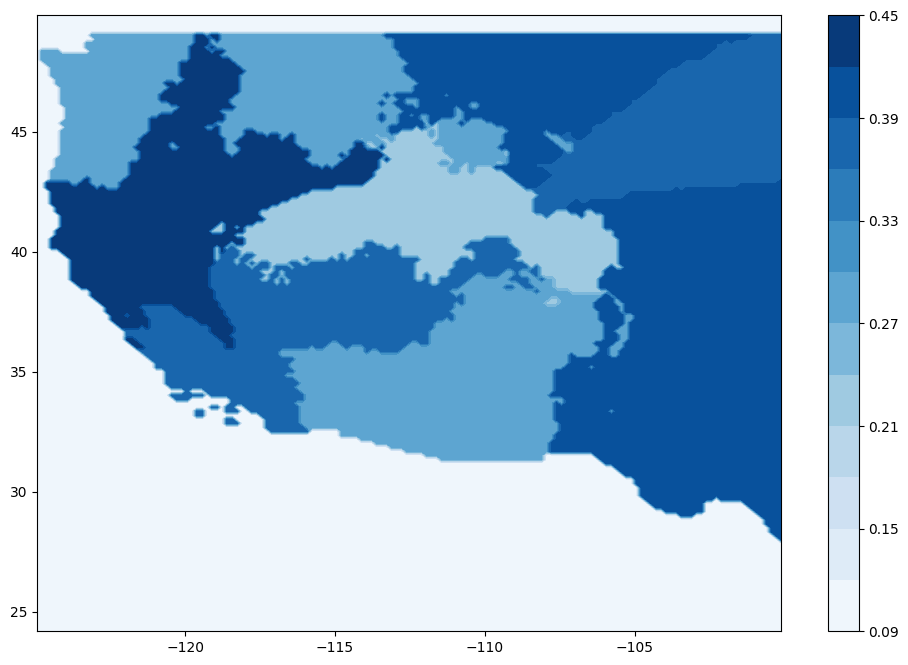

In [33]:
# clusters is 155x150 grid of values 0-8 -> convert to grid of same size with accuracy values

cluster_map_raw = np.load("clusters.npy")
cluster_map = np.where(np.isnan(cluster_map_raw), -1, cluster_map_raw)  # replace NaNs with -1
cluster_map = cluster_map.astype(int) # convert to integer
# replace all cluster numbers with their corresponding accuracy 
cluster_map = mean_accuracies[cluster_map]
cluster_map = np.where(np.isnan(cluster_map_raw), 0.1, cluster_map)  # replace where NaNs originally were with 0
plt.figure(figsize=(12, 8))
xx, yy = np.meshgrid(lon, lat)
plt.contourf(xx, yy, cluster_map, levels=10, cmap="Blues")
plt.colorbar()
plt.show()


### Confusion Matrix


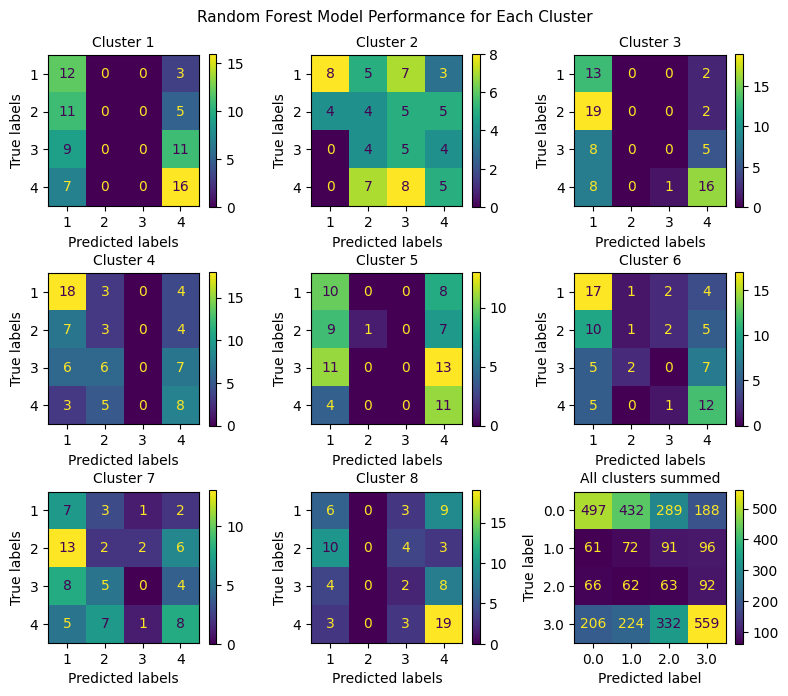

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(predictions, correct_labels, title=""):
    """ Plot the confusion matrices for a model for each cluster
    Args: 
        predictions (list): A list of 8 lists, where the ith list corresponds to the model predictions for cluster i+1.
        correct_labels (list): A list of 8 lists, where the ith list corresponds to the actual labels for cluster i+1
        title (str) (optioanl): A title for the figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,7))
    spec = fig.add_gridspec(2, 4)
    flattened_axes = axes.flatten()
    for i in range(8):
        a = flattened_axes[i]
        ConfusionMatrixDisplay.from_predictions([int(x + 1) for x in correct_labels[i]], [int(x + 1) for x in predictions[i]], ax=a)
        a.set_title(label=f'Cluster {i+1}', fontdict={'fontsize':10})
        a.set_xlabel(xlabel='Predicted labels',fontdict={'fontsize':10})
        a.set_ylabel(ylabel='True labels',fontdict={'fontsize':10})
        i += 1
    ConfusionMatrixDisplay.from_predictions(np.array(predictions).flatten(),np.array(correct_labels).flatten(), ax=flattened_axes[8])
    flattened_axes[8].set_title(label="All clusters summed", fontdict={'fontsize':10})
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()  
    plt.show()

plot_confusion_matrices(conf_preds, conf_labels, "Random Forest Model Performance for Each Cluster")

## Testing Hyperparameters

Use GridSearchCV library to test different values for different parameters


In [35]:
# params = {
#     'max_depth': [1,2,3,5,10,20, 50, 100, 150, 200, 500, None],
#     'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
#     'n_estimators': [10,25,30,50,100,200]
# }

# # Assuming we have a list of clusters called 'clusters'
# # and a function 'get_cluster_data' that returns X_train and y_train for a given cluster
# best_params = {}

# for i in range(len(clusters)):
#     X_train, _, y_train, _ = get_cluster_data(i)
#     # Instantiate the grid search model
#     grid_search = GridSearchCV(estimator=rf,
#                             param_grid=params,
#                             cv = 4,
#                             n_jobs=-1, verbose=1, scoring="accuracy")

#     grid_search.fit(X_train, y_train)
        
#         # Store the best parameters for the current cluster
#     best_params[i] = grid_search.best_params_
#     best_score = grid_search.best_score_
#     best_esty = grid_search.best_estimator_
#     print(f"best accuracy cluster {i}: {best_score}")
#     print(f"best estimators cluster {i}: {best_esty}")
#     print(f"best params for cluster {i}: {best_params[i]}")


## Trying Neural Network

Creating and training a logistic regression model


#### Model


In [36]:
# change to built in methods
class RainPrediction(nn.Module):
    def __init__(self, num_regions, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(num_regions, 20),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(20, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    

#### Training


In [37]:
def gradient_descent(model, loss_func, train_dataset, valid_dataset, optimizer, steps=5000, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    losses = []
    valid_losses = []
    for step in tqdm(range(steps)):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for x_valid_batch, y_valid_batch in valid_loader:
                valid_loss = loss_func(model(x_valid_batch), y_valid_batch)
                running_valid_loss += valid_loss.item()
        avg_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        if (step + 1) % 10 == 0:
            print(f"Step {step+1}/{steps}, Training Loss: {avg_loss}, Validation Loss: {avg_valid_loss}")

    print(f"Final training loss: {losses[-1]}")
    print(f"Final validation loss: {valid_losses[-1]}")

    return losses, valid_losses


def calculate_accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        total = y.size(0)
        return correct / total, predicted

# Iterate for all 8 clusters
nn_train_predictions_all_clusters = []
nn_test_predictions_all_clusters = []
nn_train_labels_all_clusters = []
nn_test_labels_all_clusters = []

for i in range(len(clusters)):
    print(f"\nBegin training model for cluster {i+1}")
    # Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Initialize the model and optimizer
    model = RainPrediction(X_train.shape[1], 4)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Run the training
    losses, valid_losses = gradient_descent(
        model, nn.CrossEntropyLoss(), train_dataset, test_dataset, optimizer, steps=150
    )

    train_accuracy, nn_train_predictions = calculate_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy, nn_test_predictions = calculate_accuracy(model, X_test_tensor, y_test_tensor)

    nn_train_predictions_all_clusters.append(nn_train_predictions.tolist())
    nn_test_predictions_all_clusters.append(nn_test_predictions.tolist())
    nn_train_labels_all_clusters.append(y_train_tensor.tolist())
    nn_test_labels_all_clusters.append(y_test_tensor.tolist())

    print(f"Training accuracy for cluster {i+1}: {train_accuracy * 100}%")
    print(f"Test accuracy for cluster {i+1}: {test_accuracy * 100}%")


Begin training model for cluster 1


 19%|█▉        | 29/150 [00:00<00:01, 99.22it/s]

Step 10/150, Training Loss: 1.3474848812276667, Validation Loss: 1.3658613562583923
Step 20/150, Training Loss: 1.29097703370181, Validation Loss: 1.4202269911766052
Step 30/150, Training Loss: 1.240561767057939, Validation Loss: 1.3118047714233398


 38%|███▊      | 57/150 [00:00<00:00, 120.76it/s]

Step 40/150, Training Loss: 1.2267817800695247, Validation Loss: 1.3593252301216125
Step 50/150, Training Loss: 1.2307583418759434, Validation Loss: 1.4194980263710022
Step 60/150, Training Loss: 1.1607158509167759, Validation Loss: 1.4132225513458252


 57%|█████▋    | 85/150 [00:00<00:00, 128.55it/s]

Step 70/150, Training Loss: 1.135131304914301, Validation Loss: 1.4618163704872131
Step 80/150, Training Loss: 1.114842171018774, Validation Loss: 1.3773722648620605
Step 90/150, Training Loss: 1.0602121190591292, Validation Loss: 1.4597712755203247


 83%|████████▎ | 124/150 [00:01<00:00, 125.60it/s]

Step 100/150, Training Loss: 1.0690146305344321, Validation Loss: 1.3837913274765015
Step 110/150, Training Loss: 1.0583586909554221, Validation Loss: 1.4046319723129272
Step 120/150, Training Loss: 1.015437906438654, Validation Loss: 1.4754319787025452


100%|██████████| 150/150 [00:01<00:00, 116.55it/s]


Step 130/150, Training Loss: 0.9951604821465232, Validation Loss: 1.4982218146324158
Step 140/150, Training Loss: 1.0076957724311135, Validation Loss: 1.5913969278335571
Step 150/150, Training Loss: 0.974864358251745, Validation Loss: 1.6066424250602722
Final training loss: 0.974864358251745
Final validation loss: 1.6066424250602722
Training accuracy for cluster 1: 58.662613981762924%
Test accuracy for cluster 1: 28.37837837837838%

Begin training model for cluster 2


 17%|█▋        | 26/150 [00:00<00:01, 119.73it/s]

Step 10/150, Training Loss: 1.3649719628420742, Validation Loss: 1.422297477722168
Step 20/150, Training Loss: 1.3386661898006091, Validation Loss: 1.4274837374687195
Step 30/150, Training Loss: 1.3245892416347156, Validation Loss: 1.5056535601615906


 41%|████▏     | 62/150 [00:00<00:00, 113.47it/s]

Step 40/150, Training Loss: 1.2709153673865579, Validation Loss: 1.5034785866737366
Step 50/150, Training Loss: 1.278097076849504, Validation Loss: 1.4313679337501526
Step 60/150, Training Loss: 1.2125328237360173, Validation Loss: 1.4885454773902893


 57%|█████▋    | 86/150 [00:00<00:00, 114.35it/s]

Step 70/150, Training Loss: 1.2089155912399292, Validation Loss: 1.4922015070915222
Step 80/150, Training Loss: 1.1851247549057007, Validation Loss: 1.6118575930595398
Step 90/150, Training Loss: 1.1871502291072498, Validation Loss: 1.7327042818069458


 81%|████████▏ | 122/150 [00:01<00:00, 115.44it/s]

Step 100/150, Training Loss: 1.120211200280623, Validation Loss: 1.7653833031654358
Step 110/150, Training Loss: 1.1092835664749146, Validation Loss: 1.6961349844932556
Step 120/150, Training Loss: 1.0578675270080566, Validation Loss: 1.8049739599227905


100%|██████████| 150/150 [00:01<00:00, 114.39it/s]


Step 130/150, Training Loss: 1.0489118153398687, Validation Loss: 1.7726572155952454
Step 140/150, Training Loss: 1.0771365057338367, Validation Loss: 1.7917016744613647
Step 150/150, Training Loss: 1.0043233036994934, Validation Loss: 1.8108277916908264
Final training loss: 1.0043233036994934
Final validation loss: 1.8108277916908264
Training accuracy for cluster 2: 61.09422492401215%
Test accuracy for cluster 2: 25.675675675675674%

Begin training model for cluster 3


 16%|█▌        | 24/150 [00:00<00:01, 115.32it/s]

Step 10/150, Training Loss: 1.2665955803611062, Validation Loss: 1.2882336378097534
Step 20/150, Training Loss: 1.202906315976923, Validation Loss: 1.281802475452423
Step 30/150, Training Loss: 1.1702618382193826, Validation Loss: 1.2859910130500793


 40%|████      | 60/150 [00:00<00:00, 112.52it/s]

Step 40/150, Training Loss: 1.1543793949213894, Validation Loss: 1.3384361863136292
Step 50/150, Training Loss: 1.1403964216058904, Validation Loss: 1.3909547924995422
Step 60/150, Training Loss: 1.137384663928639, Validation Loss: 1.359596848487854


 56%|█████▌    | 84/150 [00:00<00:00, 112.25it/s]

Step 70/150, Training Loss: 1.108479765328494, Validation Loss: 1.381641149520874
Step 80/150, Training Loss: 1.0631723999977112, Validation Loss: 1.4939602613449097
Step 90/150, Training Loss: 1.0728502544489773, Validation Loss: 1.4321737885475159


 72%|███████▏  | 108/150 [00:00<00:00, 111.36it/s]

Step 100/150, Training Loss: 1.0458937341516668, Validation Loss: 1.526693046092987
Step 110/150, Training Loss: 1.0350507551973516, Validation Loss: 1.5756545066833496


 87%|████████▋ | 130/150 [00:01<00:00, 78.39it/s] 

Step 120/150, Training Loss: 0.9778482859784906, Validation Loss: 1.5355207920074463
Step 130/150, Training Loss: 0.9795334989374335, Validation Loss: 1.6095437407493591
Step 140/150, Training Loss: 0.9555860432711515, Validation Loss: 1.6613988280296326


100%|██████████| 150/150 [00:01<00:00, 97.78it/s]


Step 150/150, Training Loss: 1.0084351247007197, Validation Loss: 1.8178171515464783
Final training loss: 1.0084351247007197
Final validation loss: 1.8178171515464783
Training accuracy for cluster 3: 59.57446808510638%
Test accuracy for cluster 3: 28.37837837837838%

Begin training model for cluster 4


  8%|▊         | 12/150 [00:00<00:01, 114.89it/s]

Step 10/150, Training Loss: 1.3285101652145386, Validation Loss: 1.2878081798553467
Step 20/150, Training Loss: 1.2869889302687212, Validation Loss: 1.2978637218475342


 16%|█▌        | 24/150 [00:00<00:01, 114.50it/s]

Step 30/150, Training Loss: 1.2458245754241943, Validation Loss: 1.3313875794410706


 32%|███▏      | 48/150 [00:00<00:00, 111.03it/s]

Step 40/150, Training Loss: 1.2211423787203701, Validation Loss: 1.3250133395195007
Step 50/150, Training Loss: 1.1680903814055703, Validation Loss: 1.4250959753990173


 40%|████      | 60/150 [00:00<00:00, 110.83it/s]

Step 60/150, Training Loss: 1.1640987504612317, Validation Loss: 1.4574898481369019


 48%|████▊     | 72/150 [00:00<00:00, 110.59it/s]

Step 70/150, Training Loss: 1.1109620928764343, Validation Loss: 1.4842327237129211
Step 80/150, Training Loss: 1.0959926843643188, Validation Loss: 1.5840004682540894


 56%|█████▌    | 84/150 [00:00<00:00, 111.46it/s]

Step 90/150, Training Loss: 1.0950012423775413, Validation Loss: 1.5618035793304443


 72%|███████▏  | 108/150 [00:00<00:00, 110.36it/s]

Step 100/150, Training Loss: 1.0494127869606018, Validation Loss: 1.6279402375221252
Step 110/150, Training Loss: 1.087154128334739, Validation Loss: 1.6233736872673035


 80%|████████  | 120/150 [00:01<00:00, 111.43it/s]

Step 120/150, Training Loss: 0.9920587106184526, Validation Loss: 1.68876451253891


 88%|████████▊ | 132/150 [00:01<00:00, 111.69it/s]

Step 130/150, Training Loss: 0.978568895296617, Validation Loss: 1.7355638146400452
Step 140/150, Training Loss: 1.0224994691935452, Validation Loss: 1.7490947842597961


100%|██████████| 150/150 [00:01<00:00, 111.30it/s]


Step 150/150, Training Loss: 0.9344509569081393, Validation Loss: 1.8642343878746033
Final training loss: 0.9344509569081393
Final validation loss: 1.8642343878746033
Training accuracy for cluster 4: 61.55015197568389%
Test accuracy for cluster 4: 43.24324324324324%

Begin training model for cluster 5


  8%|▊         | 12/150 [00:00<00:01, 112.84it/s]

Step 10/150, Training Loss: 1.3877792250026355, Validation Loss: 1.4141972064971924
Step 20/150, Training Loss: 1.3047930218956687, Validation Loss: 1.426287829875946


 16%|█▌        | 24/150 [00:00<00:01, 111.88it/s]

Step 30/150, Training Loss: 1.2957134355198254, Validation Loss: 1.4693666696548462


 32%|███▏      | 48/150 [00:00<00:00, 109.94it/s]

Step 40/150, Training Loss: 1.2279125668785789, Validation Loss: 1.470090627670288
Step 50/150, Training Loss: 1.2319892103021794, Validation Loss: 1.4556519389152527


 39%|███▉      | 59/150 [00:00<00:00, 108.64it/s]

Step 60/150, Training Loss: 1.1749819733879783, Validation Loss: 1.4415071606636047


 54%|█████▍    | 81/150 [00:00<00:00, 108.70it/s]

Step 70/150, Training Loss: 1.1959687146273525, Validation Loss: 1.4901017546653748
Step 80/150, Training Loss: 1.1404107483950527, Validation Loss: 1.62086820602417
Step 90/150, Training Loss: 1.108564019203186, Validation Loss: 1.5965278148651123


 70%|███████   | 105/150 [00:00<00:00, 110.18it/s]

Step 100/150, Training Loss: 1.1227104988965122, Validation Loss: 1.543457567691803
Step 110/150, Training Loss: 1.1150502237406643, Validation Loss: 1.5270694494247437


 78%|███████▊  | 117/150 [00:01<00:00, 109.63it/s]

Step 120/150, Training Loss: 1.0615194331515918, Validation Loss: 1.6085761785507202


 93%|█████████▎| 139/150 [00:01<00:00, 108.43it/s]

Step 130/150, Training Loss: 1.0671769380569458, Validation Loss: 1.6382449865341187
Step 140/150, Training Loss: 1.0798317139798945, Validation Loss: 1.597843587398529


100%|██████████| 150/150 [00:01<00:00, 109.05it/s]


Step 150/150, Training Loss: 1.0457368167963894, Validation Loss: 1.6517452001571655
Final training loss: 1.0457368167963894
Final validation loss: 1.6517452001571655
Training accuracy for cluster 5: 56.38297872340425%
Test accuracy for cluster 5: 21.62162162162162%

Begin training model for cluster 6


  7%|▋         | 11/150 [00:00<00:01, 104.99it/s]

Step 10/150, Training Loss: 1.2820363153110852, Validation Loss: 1.2164550423622131
Step 20/150, Training Loss: 1.259122902696783, Validation Loss: 1.2151142954826355


 15%|█▌        | 23/150 [00:00<00:01, 107.35it/s]

Step 30/150, Training Loss: 1.182704210281372, Validation Loss: 1.2226078510284424


 30%|███       | 45/150 [00:00<00:00, 106.00it/s]

Step 40/150, Training Loss: 1.1752996878190474, Validation Loss: 1.2283899784088135
Step 50/150, Training Loss: 1.171993764964017, Validation Loss: 1.2918906807899475


 37%|███▋      | 56/150 [00:00<00:00, 106.41it/s]

Step 60/150, Training Loss: 1.126284035769376, Validation Loss: 1.2985232472419739


 52%|█████▏    | 78/150 [00:00<00:00, 104.96it/s]

Step 70/150, Training Loss: 1.1139818646691062, Validation Loss: 1.3325833678245544
Step 80/150, Training Loss: 1.1031838005239314, Validation Loss: 1.3239265084266663


 60%|██████    | 90/150 [00:00<00:00, 106.32it/s]

Step 90/150, Training Loss: 1.0735061873089184, Validation Loss: 1.3459340929985046


 67%|██████▋   | 101/150 [00:00<00:00, 105.68it/s]

Step 100/150, Training Loss: 1.0305123166604475, Validation Loss: 1.466036081314087
Step 110/150, Training Loss: 1.0296160578727722, Validation Loss: 1.4151816964149475


 75%|███████▍  | 112/150 [00:01<00:00, 106.20it/s]

Step 120/150, Training Loss: 1.0208581577647815, Validation Loss: 1.520815670490265


 89%|████████▉ | 134/150 [00:01<00:00, 107.51it/s]

Step 130/150, Training Loss: 0.9864200082692233, Validation Loss: 1.4873167276382446
Step 140/150, Training Loss: 0.9926915927366777, Validation Loss: 1.5522766709327698


100%|██████████| 150/150 [00:01<00:00, 106.55it/s]


Step 150/150, Training Loss: 0.9835579178550027, Validation Loss: 1.5216560363769531
Final training loss: 0.9835579178550027
Final validation loss: 1.5216560363769531
Training accuracy for cluster 6: 56.38297872340425%
Test accuracy for cluster 6: 35.13513513513514%

Begin training model for cluster 7


  7%|▋         | 11/150 [00:00<00:01, 108.05it/s]

Step 10/150, Training Loss: 1.4415557059374722, Validation Loss: 1.375186800956726
Step 20/150, Training Loss: 1.3785006132992832, Validation Loss: 1.4295741319656372


 15%|█▍        | 22/150 [00:00<00:01, 108.98it/s]

Step 30/150, Training Loss: 1.3615742054852573, Validation Loss: 1.57871013879776


 29%|██▉       | 44/150 [00:00<00:00, 109.06it/s]

Step 40/150, Training Loss: 1.3161549243060024, Validation Loss: 1.477029025554657
Step 50/150, Training Loss: 1.3145842227068814, Validation Loss: 1.5788365006446838


 37%|███▋      | 55/150 [00:00<00:00, 109.26it/s]

Step 60/150, Training Loss: 1.2940039201216265, Validation Loss: 1.626166820526123


 51%|█████▏    | 77/150 [00:00<00:00, 106.07it/s]

Step 70/150, Training Loss: 1.2681336728009311, Validation Loss: 1.691270112991333
Step 80/150, Training Loss: 1.255763519893993, Validation Loss: 1.7712912559509277


 59%|█████▊    | 88/150 [00:00<00:00, 106.68it/s]

Step 90/150, Training Loss: 1.2598235173658892, Validation Loss: 1.8150572180747986


 73%|███████▎  | 110/150 [00:01<00:00, 107.00it/s]

Step 100/150, Training Loss: 1.228270498189059, Validation Loss: 1.8001770377159119
Step 110/150, Training Loss: 1.19256038015539, Validation Loss: 1.8427211046218872


 87%|████████▋ | 131/150 [00:01<00:00, 83.36it/s] 

Step 120/150, Training Loss: 1.177524122324857, Validation Loss: 1.9742218852043152
Step 130/150, Training Loss: 1.1401575370268389, Validation Loss: 2.1136781573295593


100%|██████████| 150/150 [00:01<00:00, 98.48it/s]


Step 140/150, Training Loss: 1.180780660022389, Validation Loss: 2.0063424706459045
Step 150/150, Training Loss: 1.131756311113184, Validation Loss: 2.1625360250473022
Final training loss: 1.131756311113184
Final validation loss: 2.1625360250473022
Training accuracy for cluster 7: 48.17629179331307%
Test accuracy for cluster 7: 28.37837837837838%

Begin training model for cluster 8


  0%|          | 0/150 [00:00<?, ?it/s]

Step 10/150, Training Loss: 1.3575272343375466, Validation Loss: 1.4968857169151306


 15%|█▍        | 22/150 [00:00<00:01, 106.76it/s]

Step 20/150, Training Loss: 1.306710655039007, Validation Loss: 1.406182050704956
Step 30/150, Training Loss: 1.2876692793586038, Validation Loss: 1.4135282039642334


 22%|██▏       | 33/150 [00:00<00:01, 105.74it/s]

Step 40/150, Training Loss: 1.2821083935824307, Validation Loss: 1.4123605489730835


 37%|███▋      | 55/150 [00:00<00:00, 104.96it/s]

Step 50/150, Training Loss: 1.260962432081049, Validation Loss: 1.44415283203125
Step 60/150, Training Loss: 1.2242301919243552, Validation Loss: 1.4505743980407715


 44%|████▍     | 66/150 [00:00<00:00, 104.61it/s]

Step 70/150, Training Loss: 1.1938332319259644, Validation Loss: 1.5115674138069153


 59%|█████▊    | 88/150 [00:00<00:00, 104.84it/s]

Step 80/150, Training Loss: 1.1968853256919167, Validation Loss: 1.6365110278129578
Step 90/150, Training Loss: 1.1736031337217852, Validation Loss: 1.6054294109344482


 66%|██████▌   | 99/150 [00:00<00:00, 106.07it/s]

Step 100/150, Training Loss: 1.1275834007696672, Validation Loss: 1.8230275511741638


 81%|████████  | 121/150 [00:01<00:00, 105.90it/s]

Step 110/150, Training Loss: 1.092052009972659, Validation Loss: 1.7684646248817444
Step 120/150, Training Loss: 1.118754961273887, Validation Loss: 1.7035783529281616
Step 130/150, Training Loss: 1.0650581446560947, Validation Loss: 1.9506567120552063


100%|██████████| 150/150 [00:01<00:00, 105.34it/s]


Step 140/150, Training Loss: 1.0440418503501199, Validation Loss: 2.0466697812080383
Step 150/150, Training Loss: 1.012655946341428, Validation Loss: 1.9828374981880188
Final training loss: 1.012655946341428
Final validation loss: 1.9828374981880188
Training accuracy for cluster 8: 57.446808510638306%
Test accuracy for cluster 8: 28.37837837837838%

Begin training model for cluster 9


  7%|▋         | 11/150 [00:00<00:01, 108.83it/s]

Step 10/150, Training Loss: 1.3162564039230347, Validation Loss: 1.3474345803260803


 15%|█▍        | 22/150 [00:00<00:01, 107.01it/s]

Step 20/150, Training Loss: 1.3003656539050015, Validation Loss: 1.3481761813163757
Step 30/150, Training Loss: 1.2207873409444636, Validation Loss: 1.355047881603241


 22%|██▏       | 33/150 [00:00<00:01, 105.51it/s]

Step 40/150, Training Loss: 1.2515032616528599, Validation Loss: 1.372304081916809


 37%|███▋      | 55/150 [00:00<00:00, 104.86it/s]

Step 50/150, Training Loss: 1.2001897638494319, Validation Loss: 1.330631971359253
Step 60/150, Training Loss: 1.1674537333575161, Validation Loss: 1.4310654997825623


 44%|████▍     | 66/150 [00:00<00:00, 104.71it/s]

Step 70/150, Training Loss: 1.129015033895319, Validation Loss: 1.395815134048462


 59%|█████▊    | 88/150 [00:00<00:00, 105.52it/s]

Step 80/150, Training Loss: 1.124201156876304, Validation Loss: 1.3660892248153687
Step 90/150, Training Loss: 1.1452784104780718, Validation Loss: 1.3862285614013672


 66%|██████▌   | 99/150 [00:00<00:00, 105.80it/s]

Step 100/150, Training Loss: 1.0727643208070234, Validation Loss: 1.4478579759597778


 81%|████████  | 121/150 [00:01<00:00, 105.55it/s]

Step 110/150, Training Loss: 1.0869699012149463, Validation Loss: 1.4872947335243225
Step 120/150, Training Loss: 1.021728277206421, Validation Loss: 1.5833458304405212
Step 130/150, Training Loss: 1.021539493040605, Validation Loss: 1.5680779218673706


100%|██████████| 150/150 [00:01<00:00, 106.02it/s]

Step 140/150, Training Loss: 0.9480642676353455, Validation Loss: 1.7738009691238403
Step 150/150, Training Loss: 0.9954470504413951, Validation Loss: 1.654622733592987
Final training loss: 0.9954470504413951
Final validation loss: 1.654622733592987
Training accuracy for cluster 9: 56.53495440729483%
Test accuracy for cluster 9: 33.78378378378378%


### Plot Neural Network Confusion Matrices


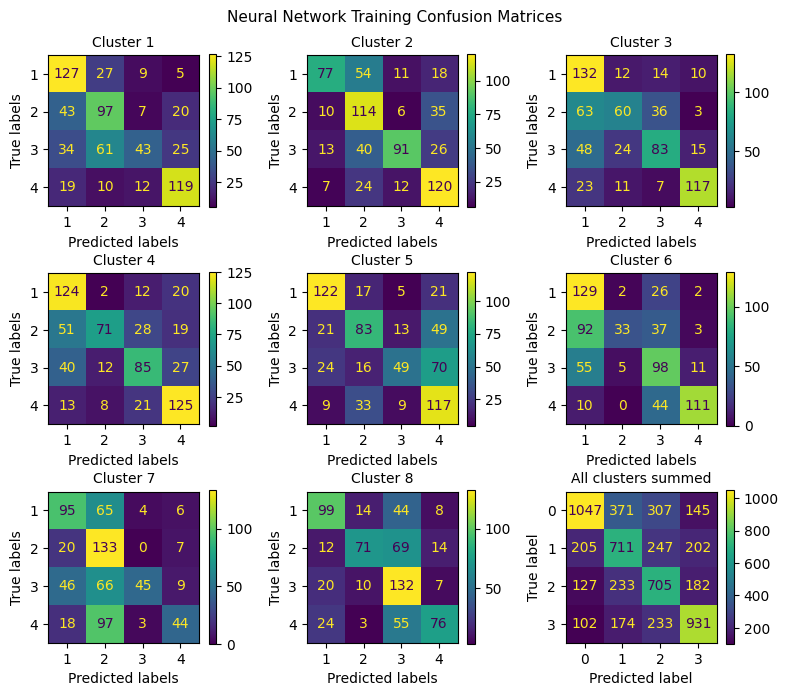

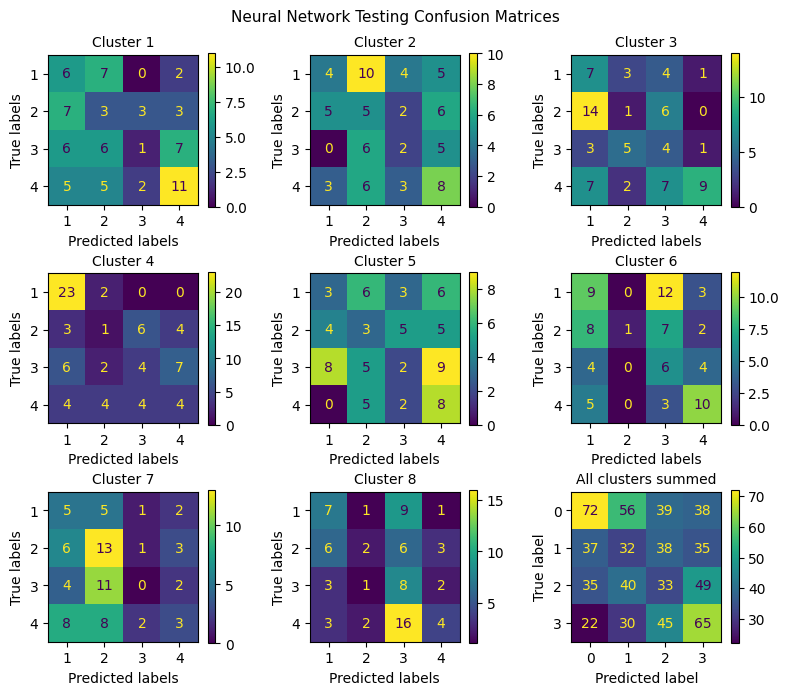

In [38]:
plot_confusion_matrices(nn_train_predictions_all_clusters,nn_train_labels_all_clusters,title="Neural Network Training Confusion Matrices")
plot_confusion_matrices(nn_test_predictions_all_clusters,nn_test_labels_all_clusters, title="Neural Network Testing Confusion Matrices")

### Plot Training and Validation Loss


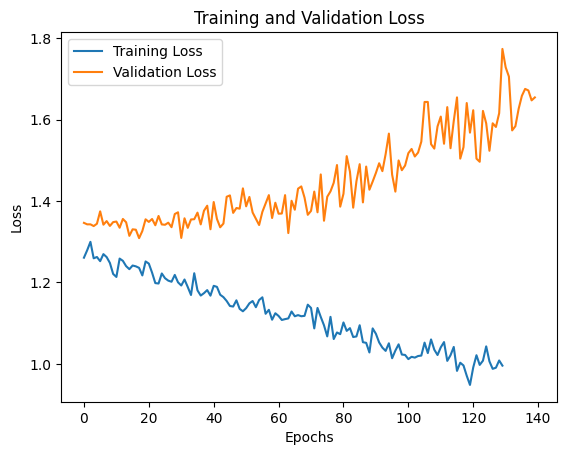

In [39]:
# Plot and label the training and validation loss values
plt.plot(losses[20:], label='Training Loss')
plt.plot(valid_losses[10:], label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

### Implement Logistic Regression


/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hayleywalters/Desktop/MLResearch/ML_rain_prediction/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

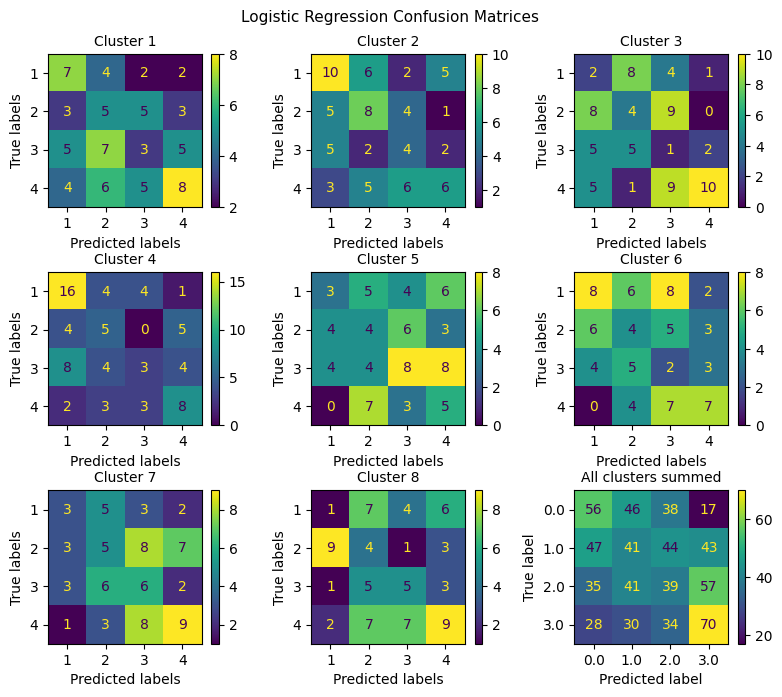

In [40]:
model = LogisticRegression()

test_preds = []
test_labels = []

for i in range(len(clusters)):
# Get data for this cluster
    X_train, X_test, y_train, y_test = get_cluster_data(i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    test_preds.append(preds.tolist())
    test_labels.append(y_test.tolist())

plot_confusion_matrices(test_preds, test_labels,title="Logistic Regression Confusion Matrices")

In [41]:
from vivit import *
# Get the dataset
prepared_dataset = download_and_prepare_dataset("sst.npz")
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

print(f'train_videos {train_videos.shape}, train_labels {train_labels.shape}')
print(f'valid_videos {valid_videos.shape}, valid_labels {valid_labels.shape}')
print(f'test_videos {test_videos.shape}, test_labels {test_labels.shape}')

trainloader = prepare_dataloader(train_videos, train_labels, "train")
print("done with trainloader")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
print("done with validloader")
testloader = prepare_dataloader(test_videos, test_labels, "test")
print("done with testloader")

train_videos (585, 24, 89, 180), train_labels (585,)
valid_videos (14, 24, 89, 180), valid_labels (14,)
test_videos (133, 24, 89, 180), test_labels (133,)
done with trainloader
done with validloader
done with testloader


In [42]:
model = run_experiment(trainloader, testloader, validloader)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.2656 - loss: 1.5049 - top-5-accuracy: 1.0000 - val_accuracy: 0.2143 - val_loss: 1.5212 - val_top-5-accuracy: 1.0000
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.2806 - loss: 1.4054 - top-5-accuracy: 1.0000 - val_accuracy: 0.0714 - val_loss: 1.4472 - val_top-5-accuracy: 1.0000
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.2502 - loss: 1.3973 - top-5-accuracy: 1.0000 - val_accuracy: 0.3571 - val_loss: 1.3943 - val_top-5-accuracy: 1.0000
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.2114 - loss: 1.4162 - top-5-accuracy: 1.0000 - val_accuracy: 0.3571 - val_loss: 1.3675 - val_top-5-accuracy: 1.0000
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.2256 - loss: 1.4138 - top-5-accuracy: 1.0000 - val_accuracy: 0.3571 - val_loss: 1.3972 - val_top-5-accuracy: 1.0000
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2234 - loss: 1.4040 - top-5-accurac